<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Deep Learning</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 


np.random.seed(123)
import math

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: f5d91394c1944f4c03b30bf16a4c3bf3a8269c62

json      : 2.0.9
pandas    : 1.1.3
tensorflow: 2.5.0
keras     : 2.4.3
matplotlib: 3.3.2
watermark : 2.1.0
numpy     : 1.19.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Load dataset

GDP data from the Federal Reserve Bank [website](https://fred.stlouisfed.org/series/GDP)

In [4]:
dataset = pd.read_csv('data/GDP.csv', header=0, parse_dates=[0], index_col=0)

It's always important to see what you are doing. You can save a lot of time like this ;)

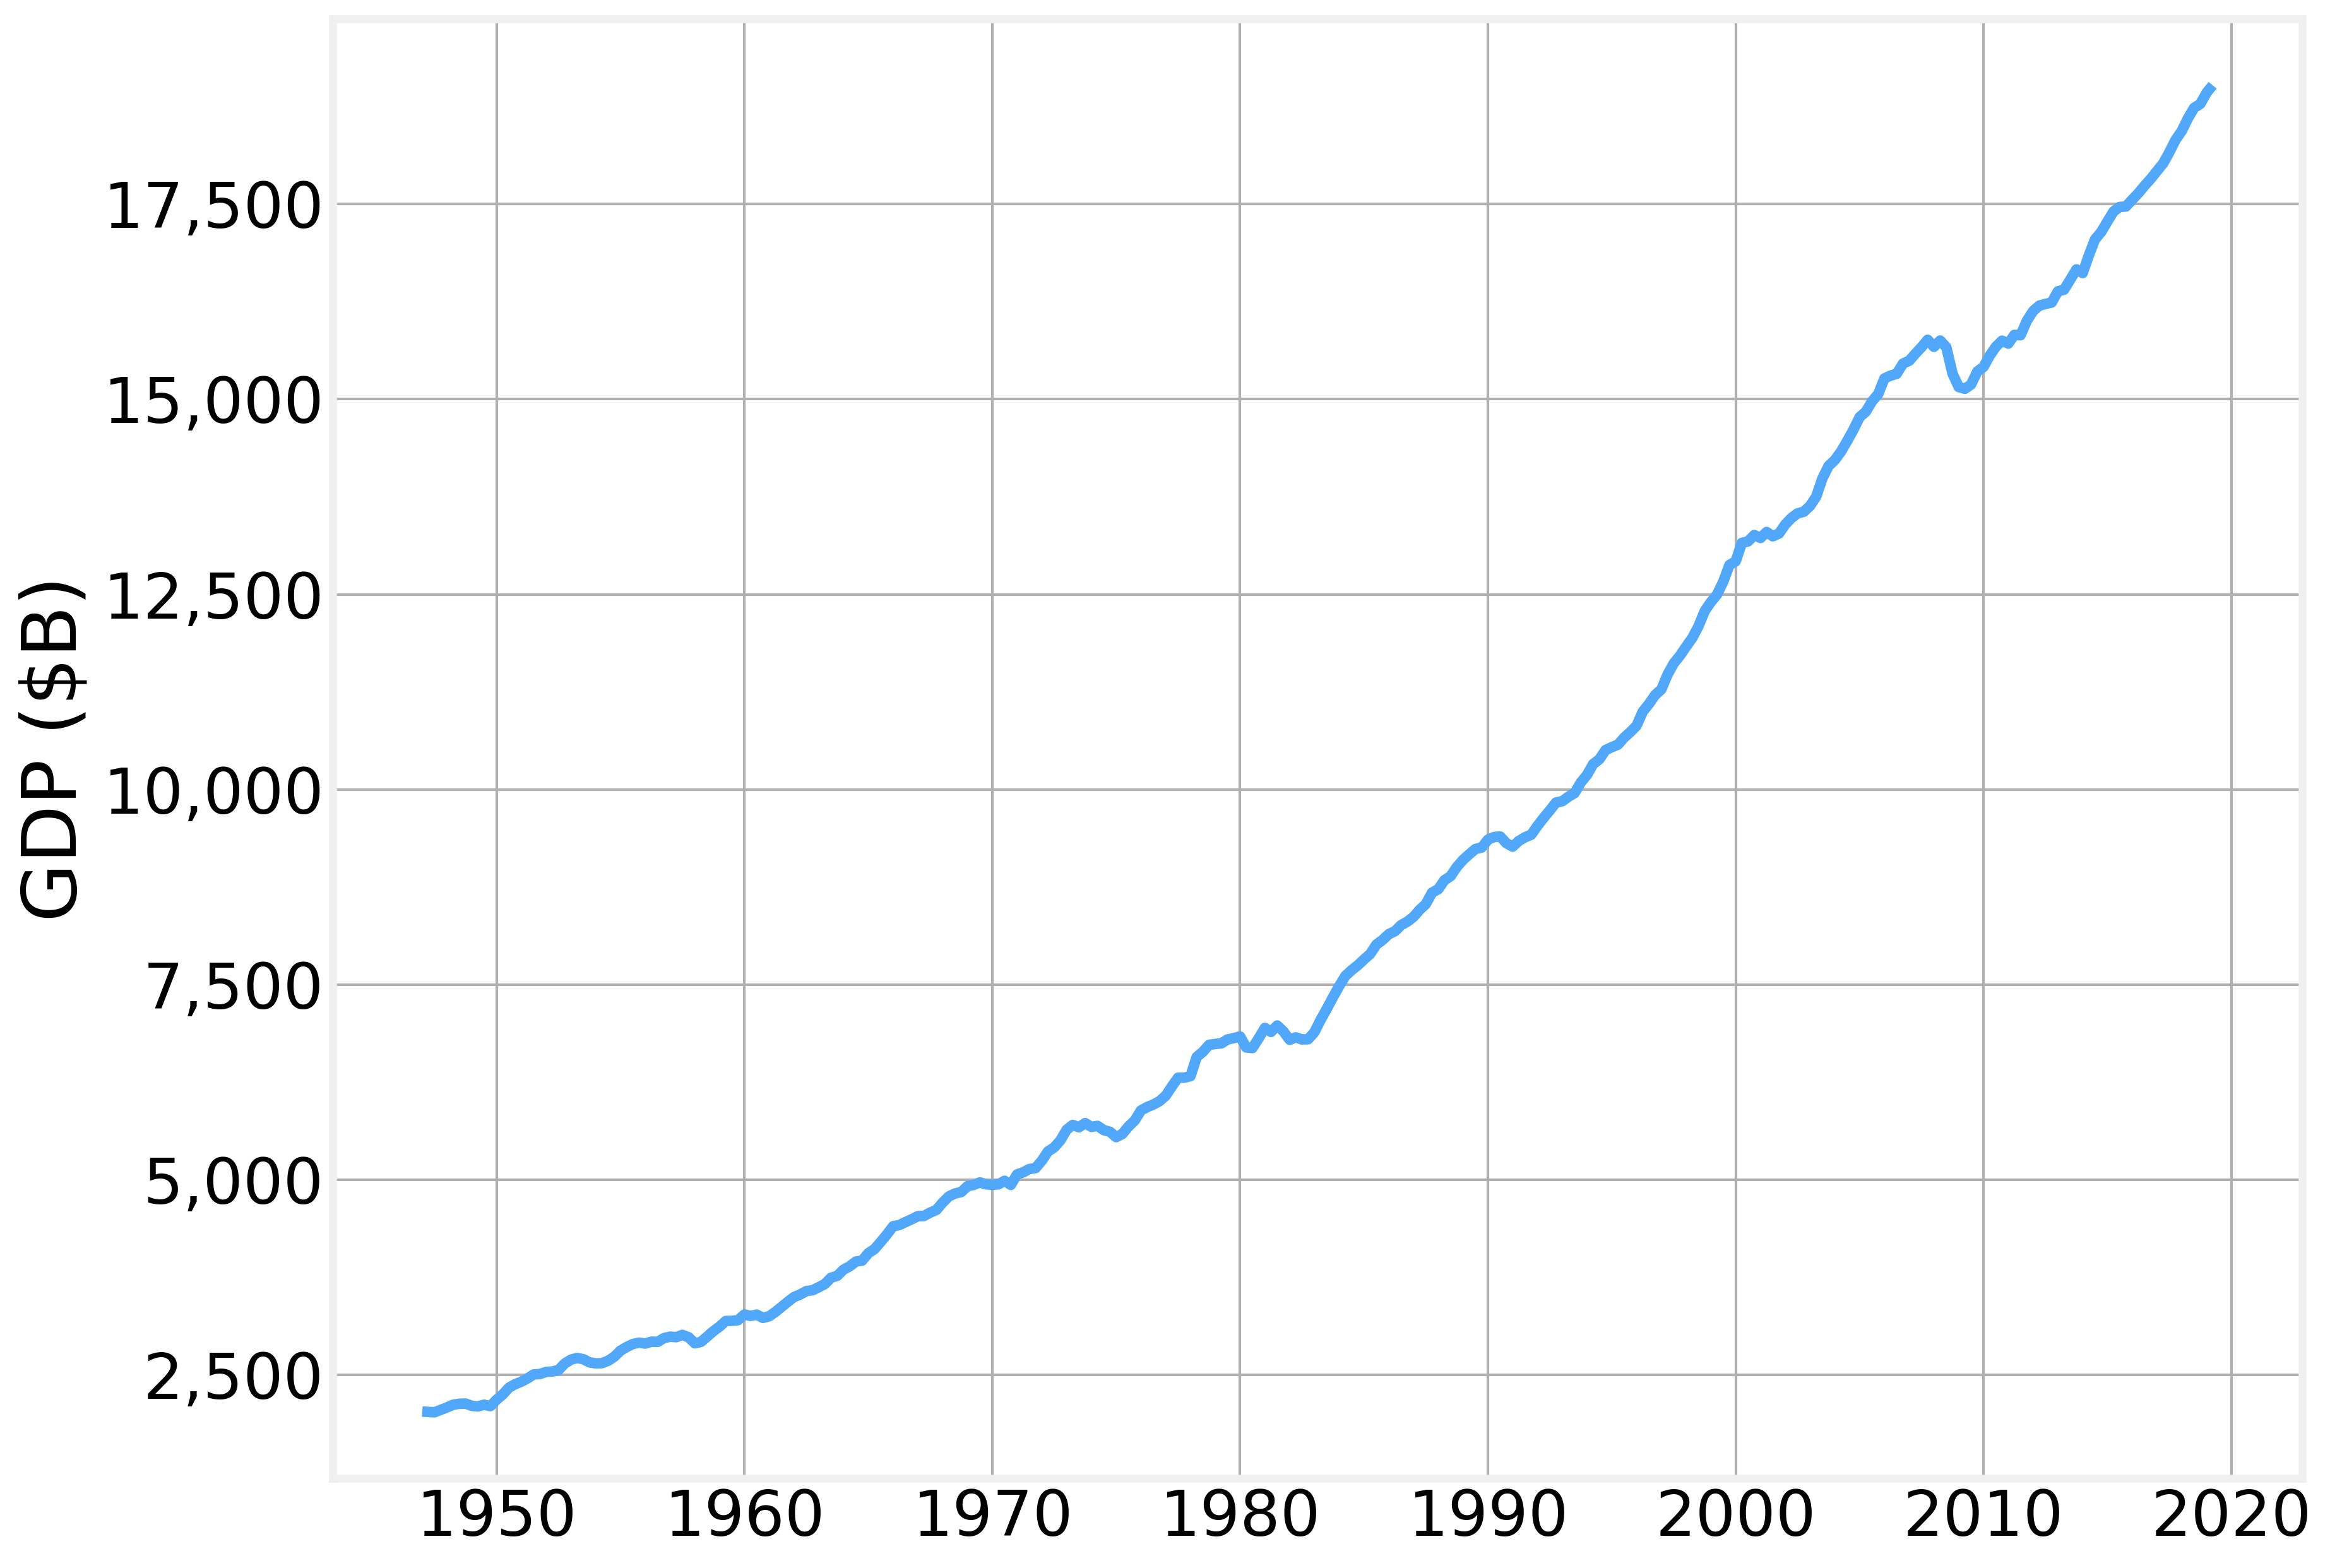

In [5]:
plt.plot(dataset['GDP'])
plt.xlabel(None)
plt.ylabel('GDP ($B)')
plt.gca().get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

You might remember the little "dip" around 2009.

## Calculate the QoQ growth
The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues. This also has the added advantage of making the timeseries (relatively) stationary

In [6]:
dataset['diff'] = 0
series = dataset['GDP'].pct_change().dropna().values.reshape(-1,1)
dataset.loc[1:, 'diff']=series

A quick plot...

Text(0, 0.5, 'count')

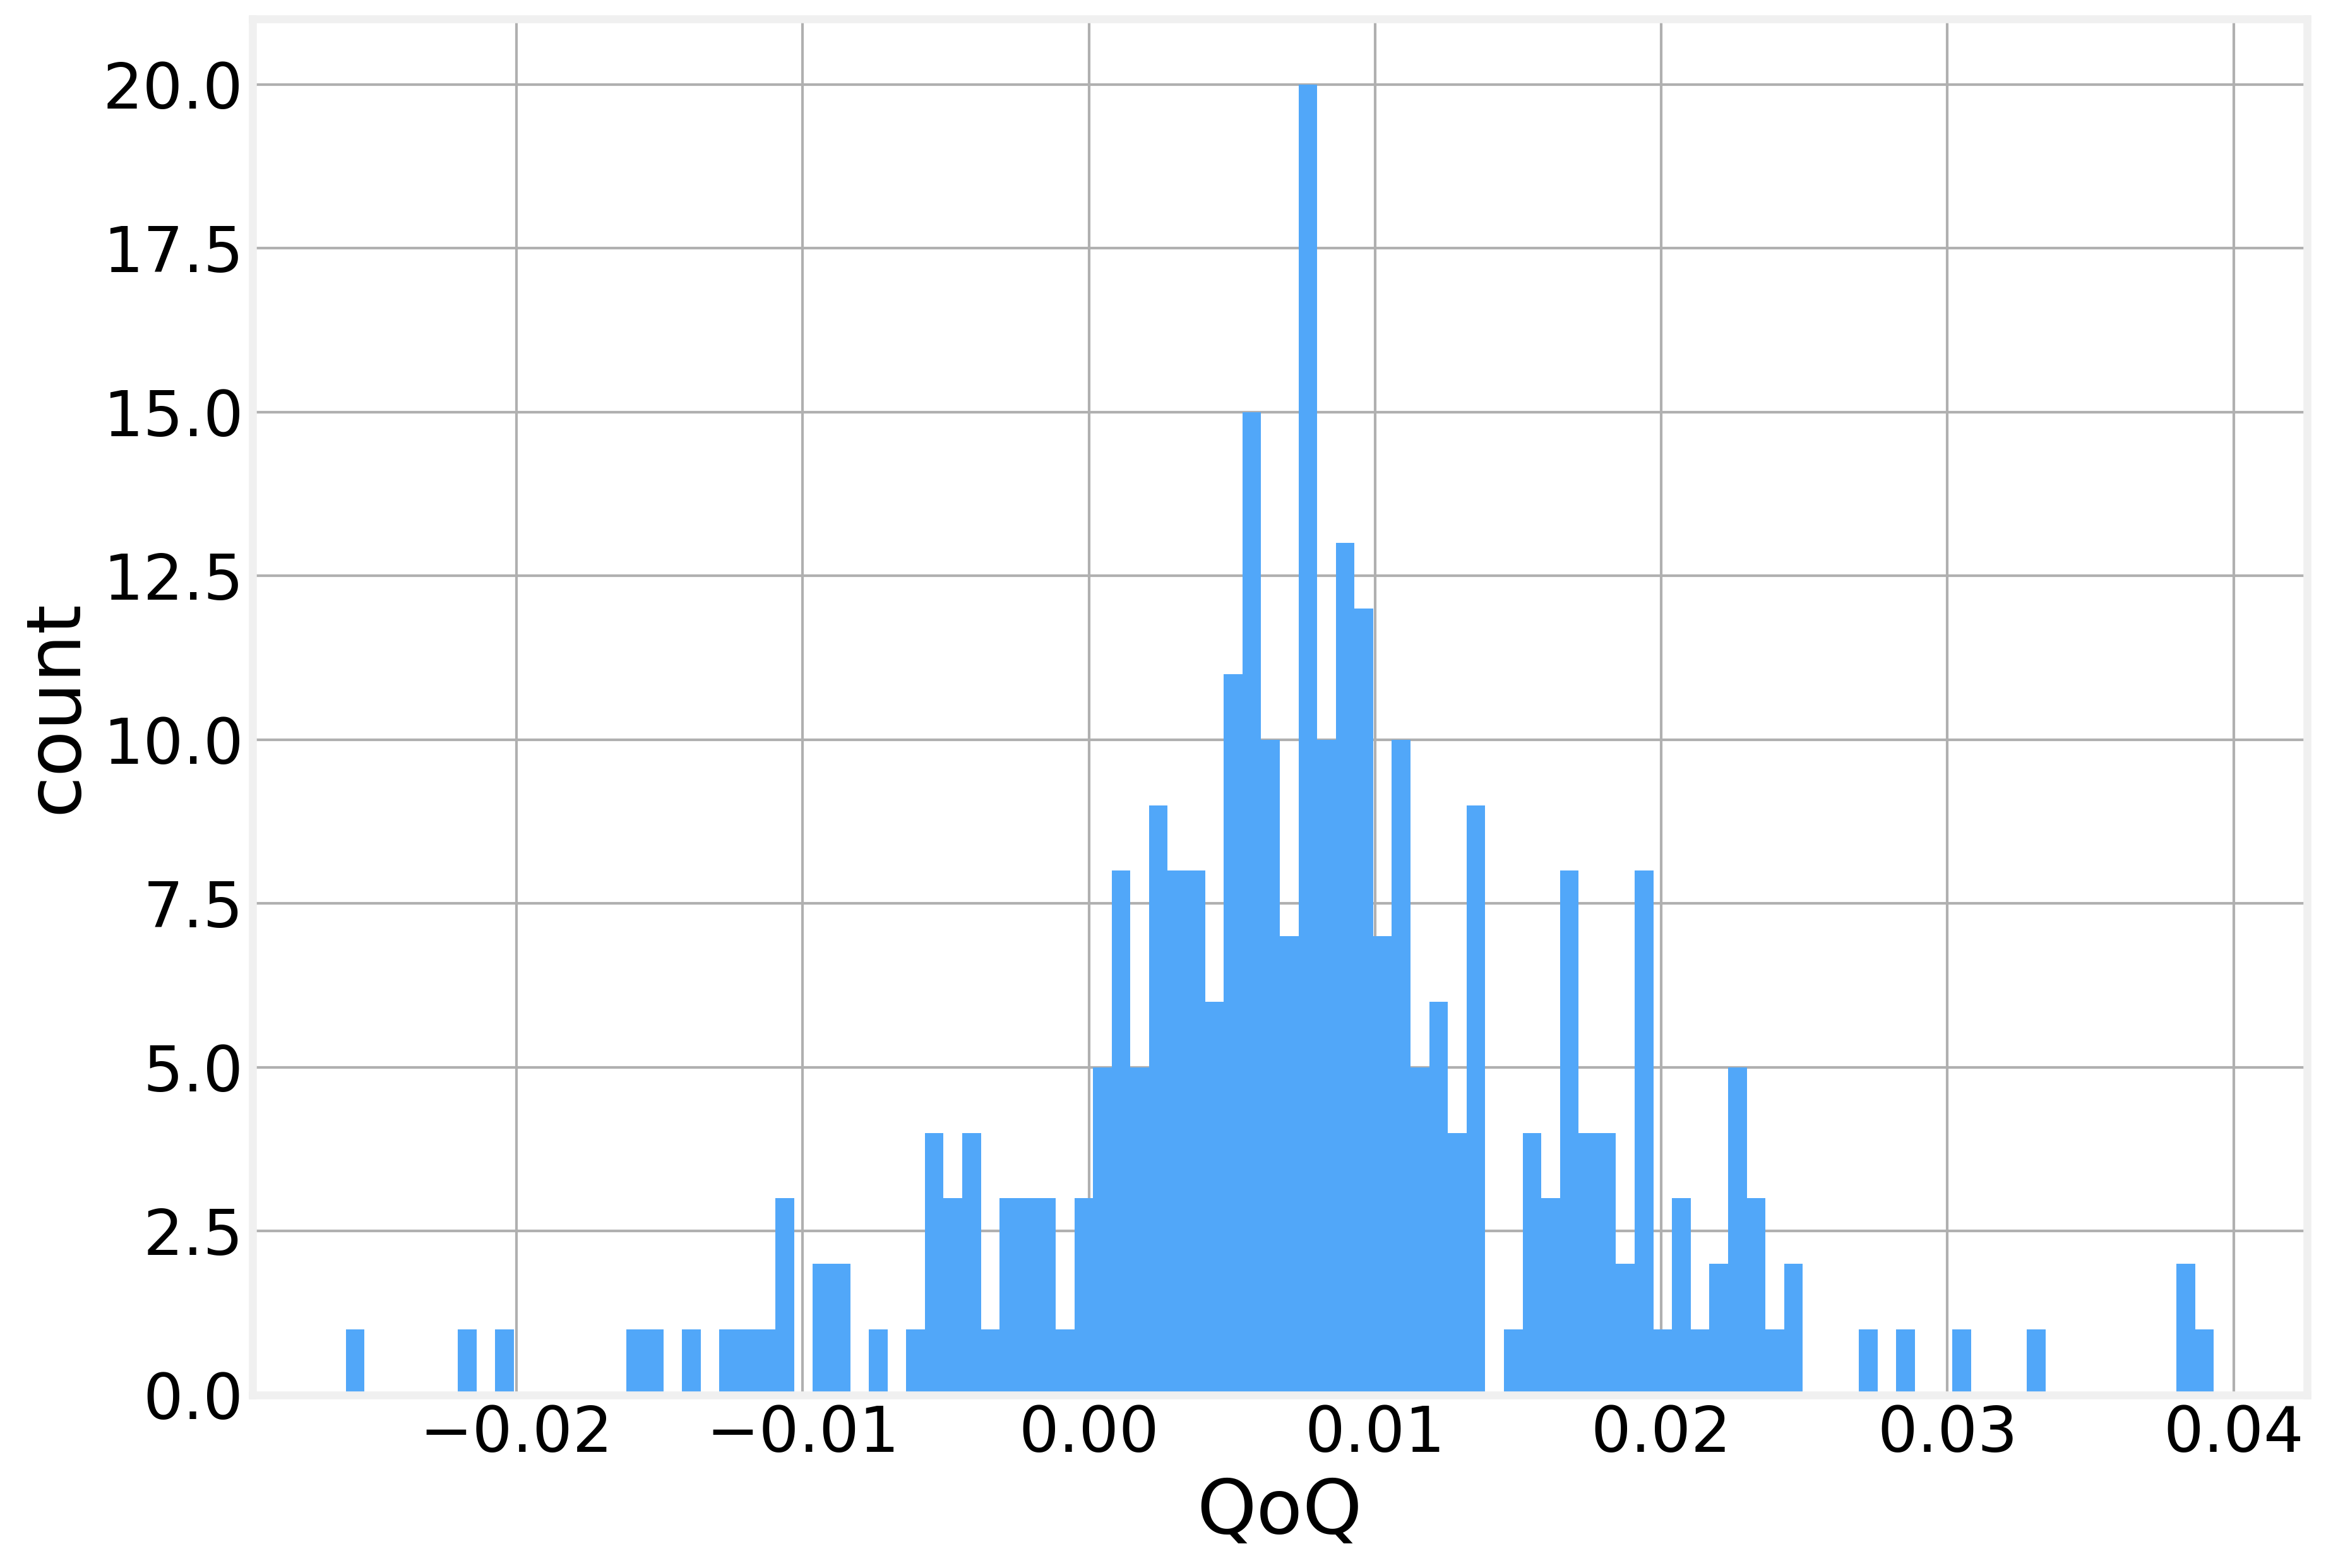

In [7]:
dataset['diff'].hist(bins=100)
plt.xlabel('QoQ')
plt.ylabel('count')

## Training and Testing datasets 
The y values are just the next x value

In [8]:
values = series.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)
X = values[:-1]
y = values[1:]

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [9]:
n_points = len(series)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 193 training points and 95 testing points


The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly 

In [10]:
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(193, 1, 1)
(95, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [11]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [12]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch, batch_size=16)

Epoch 1/100
13/13 [==============================] - 12s 1ms/step - loss: 0.1151
Epoch 2/100
13/13 [==============================] - 0s 745us/step - loss: 0.1139
Epoch 3/100
13/13 [==============================] - 0s 742us/step - loss: 0.0945
Epoch 4/100
13/13 [==============================] - 0s 777us/step - loss: 0.1005
Epoch 5/100
13/13 [==============================] - 0s 748us/step - loss: 0.0894
Epoch 6/100
13/13 [==============================] - 0s 746us/step - loss: 0.0896
Epoch 7/100
13/13 [==============================] - 0s 771us/step - loss: 0.0933
Epoch 8/100
13/13 [==============================] - 0s 730us/step - loss: 0.0872
Epoch 9/100
13/13 [==============================] - 0s 695us/step - loss: 0.0977
Epoch 10/100
13/13 [==============================] - 0s 717us/step - loss: 0.0982
Epoch 11/100
13/13 [==============================] - 0s 697us/step - loss: 0.0751
Epoch 12/100
13/13 [==============================] - 0s 691us/step - loss: 0.0940
Epoch 13/100
1

13/13 [==============================] - 0s 722us/step - loss: 0.1139
Epoch 100/100
13/13 [==============================] - 0s 737us/step - loss: 0.1040


## Make predictions

In [13]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

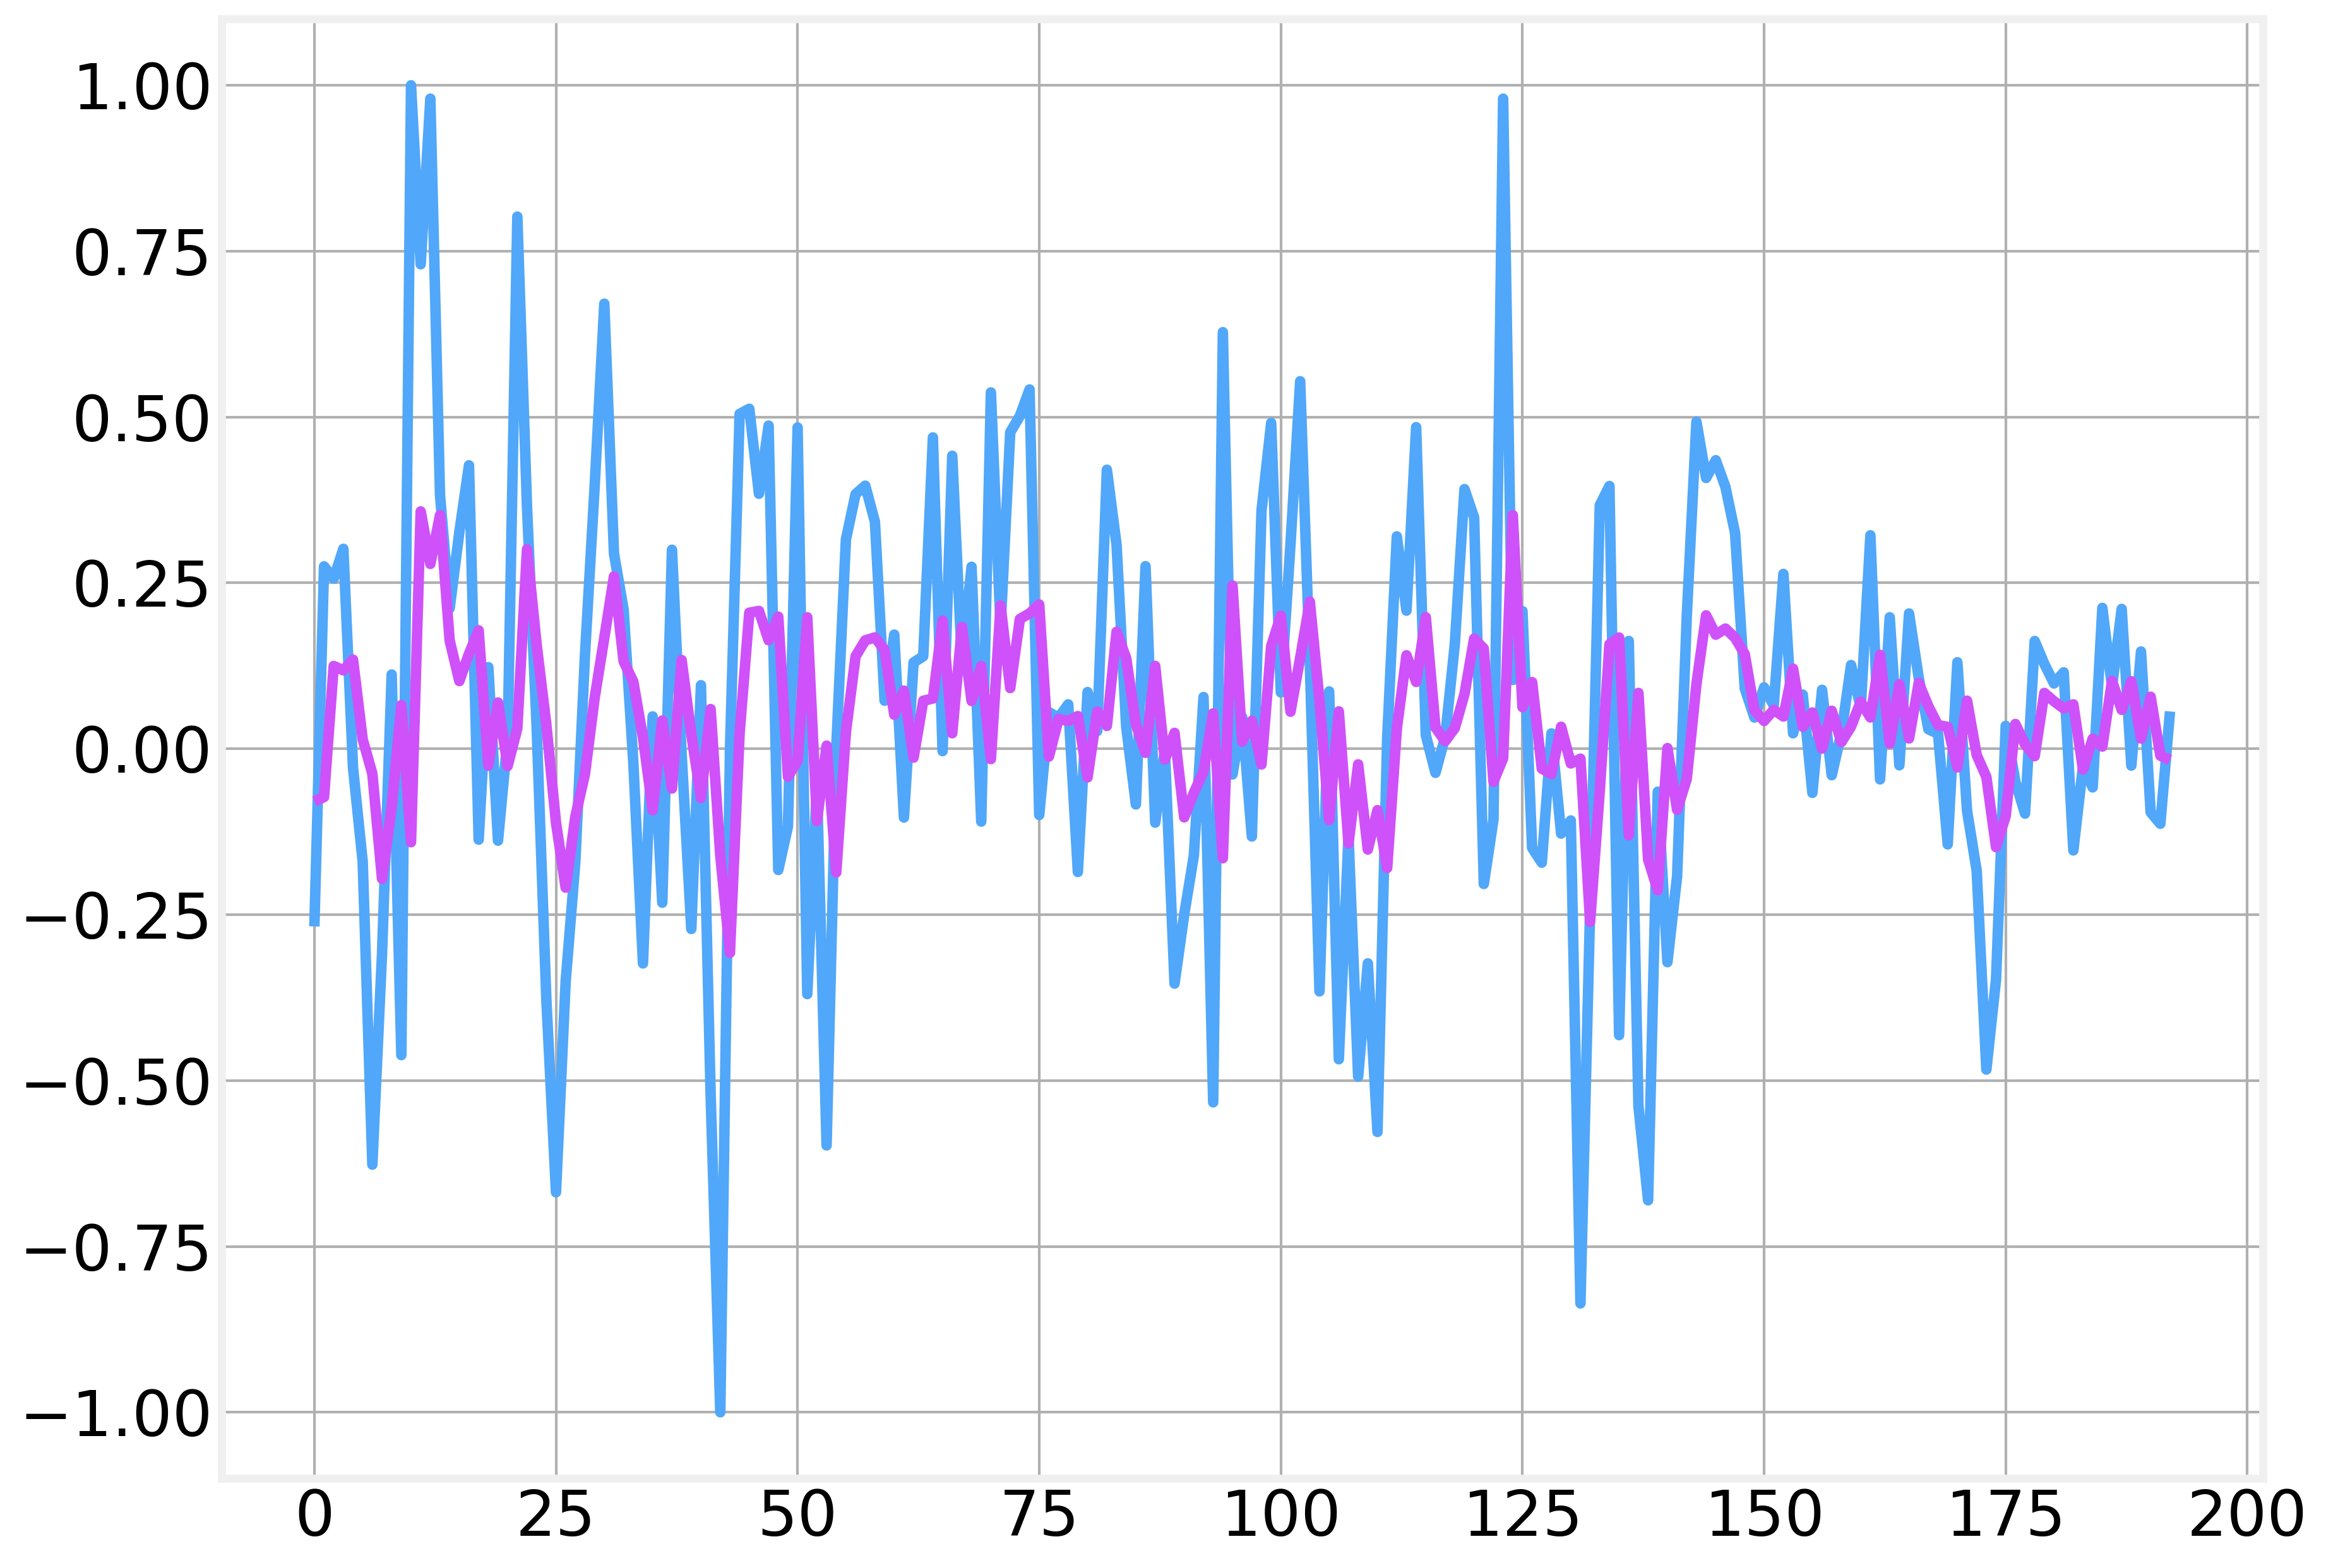

In [14]:
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train_pred)), y_train_pred)

Compute the actual values

In [15]:
dataset['RNN_train_predict'] = 1
dataset['RNN_test_predict'] = 1
dataset.loc[1:train_points+1, 'RNN_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'RNN_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['RNN_train_predict'] = dataset.iloc[0]['GDP']*dataset['RNN_train_predict'].cumprod()
dataset['RNN_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['RNN_test_predict'].cumprod()

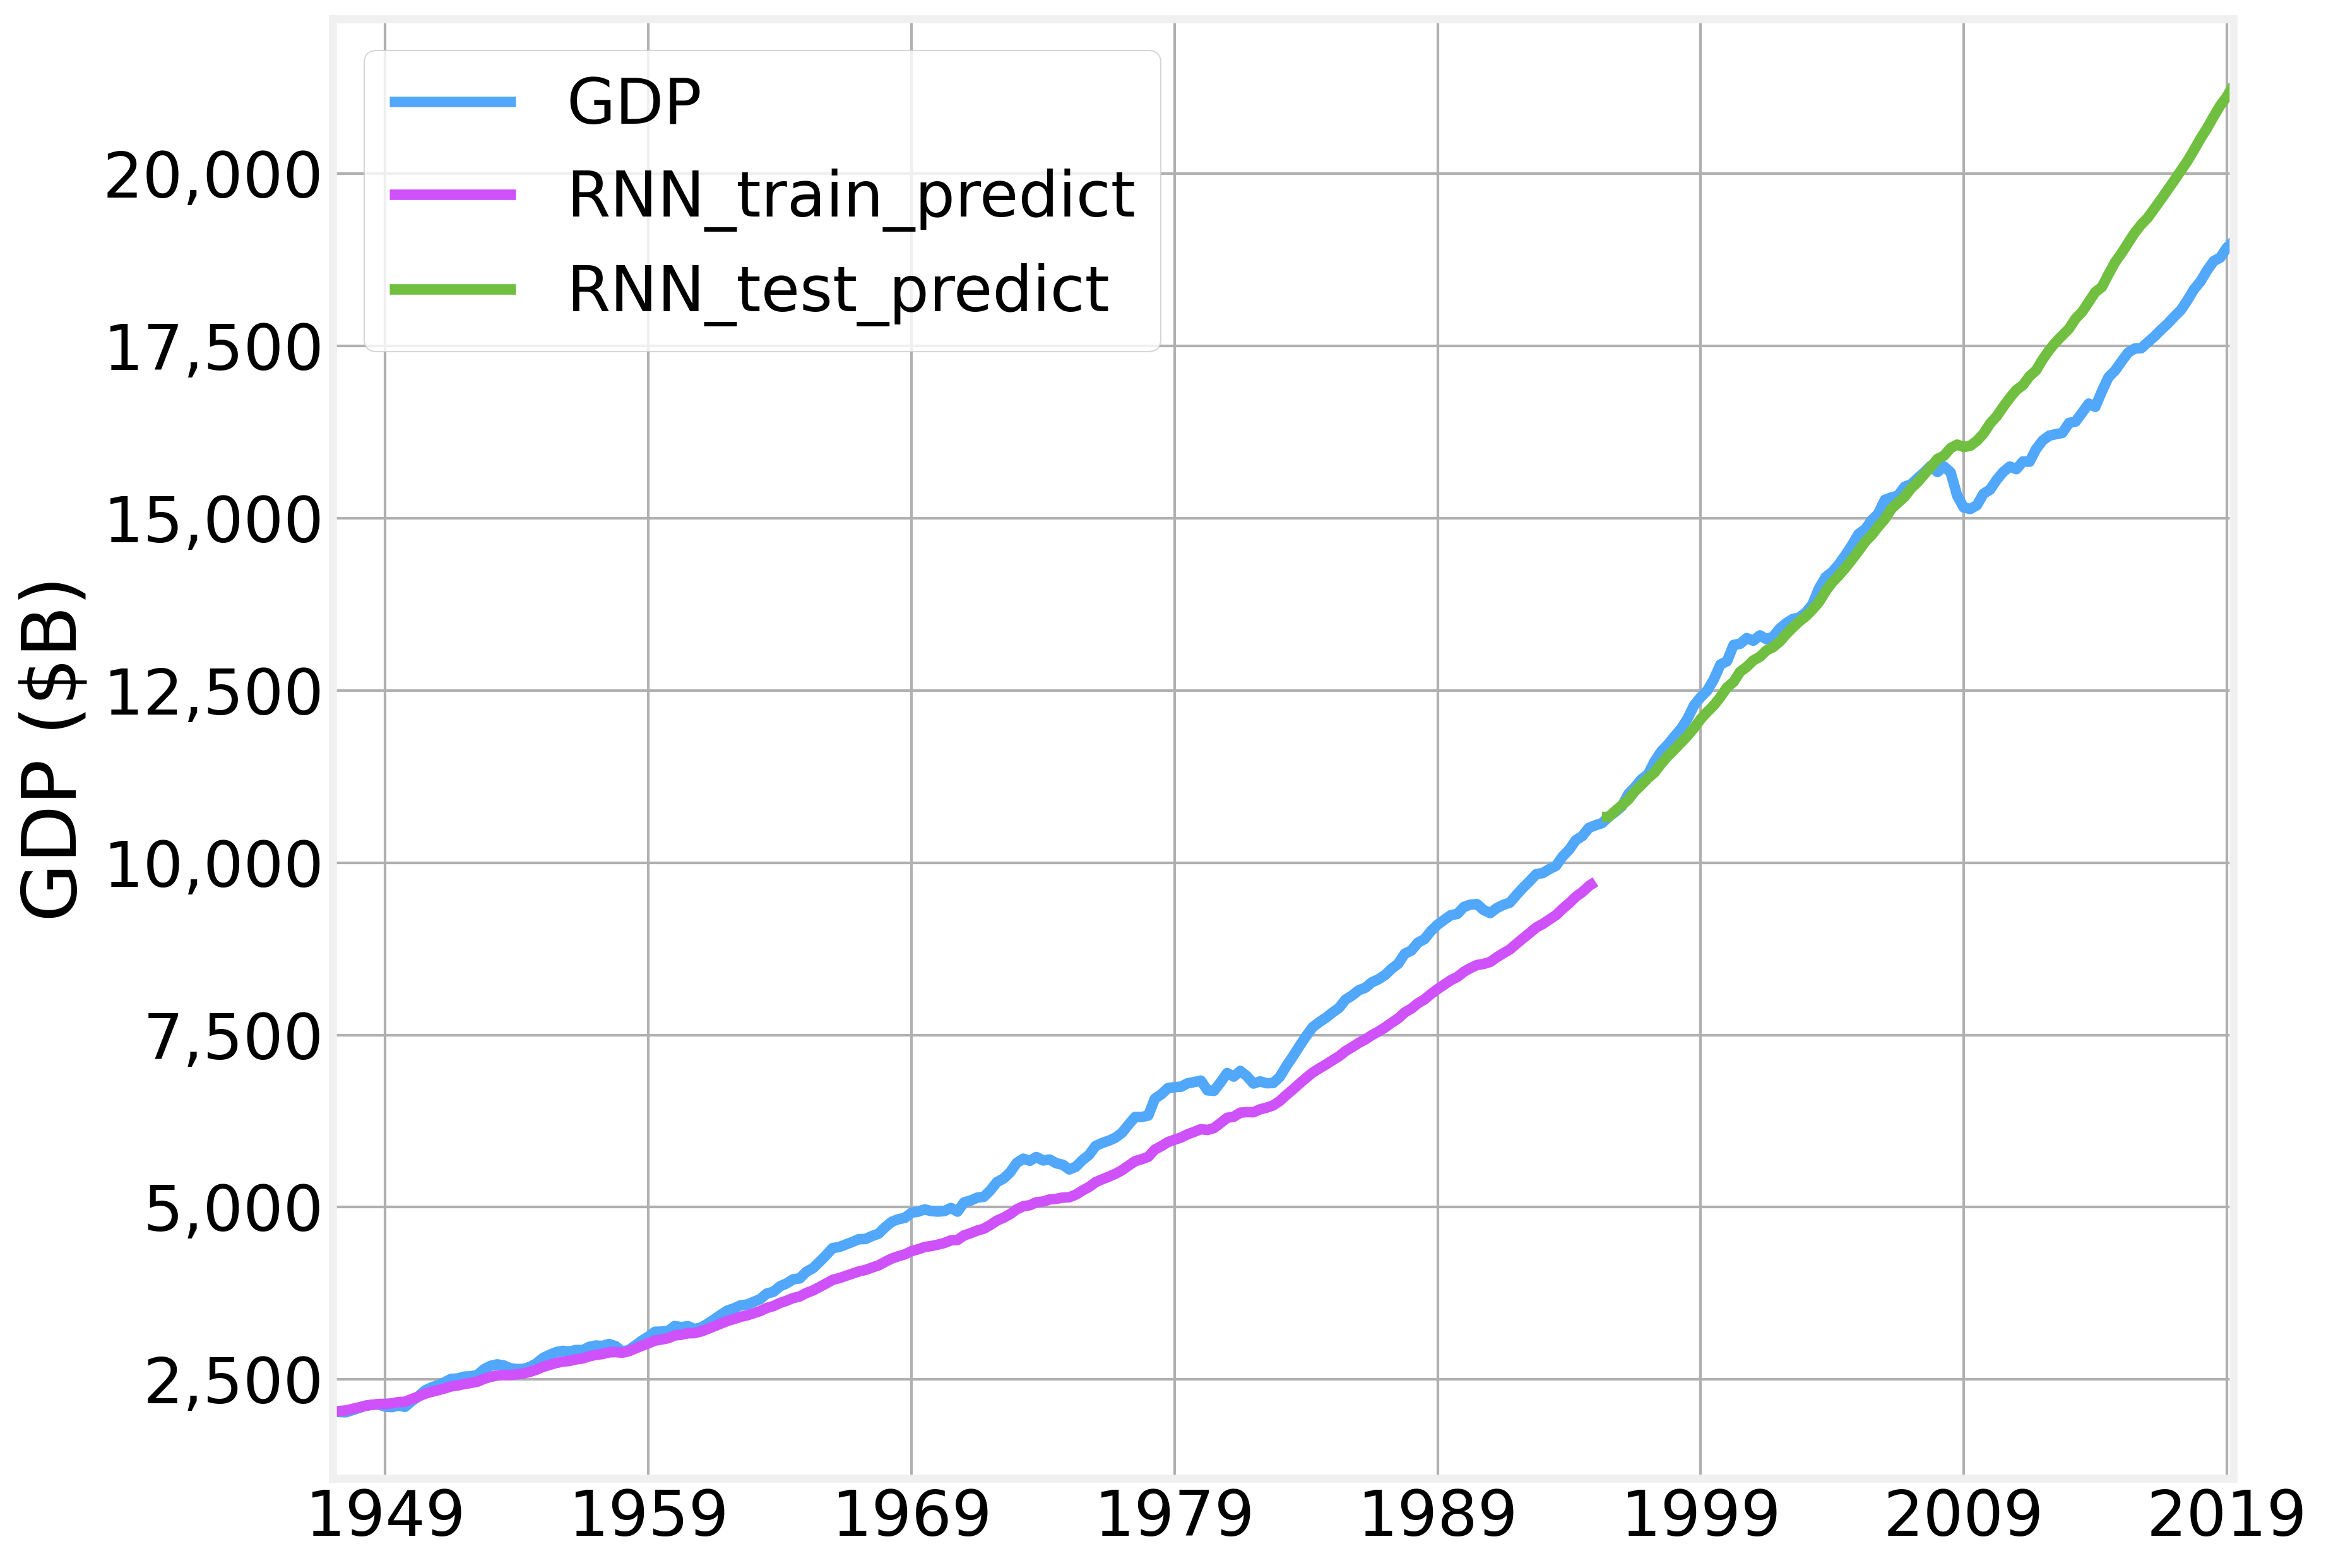

In [16]:
ax = dataset[['GDP']].plot()
dataset[['RNN_train_predict']][:train_points].plot(ax=ax)
dataset[['RNN_test_predict']][train_points:].plot(ax=ax)
ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

## LSTM
Let's now try using a slightly more sophisticated architecture

In [17]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [19]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
7/7 [==============================] - 2s 2ms/step - loss: 0.1061
Epoch 2/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1130
Epoch 3/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0988
Epoch 4/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0942
Epoch 5/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1062
Epoch 6/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0945
Epoch 7/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1121
Epoch 8/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1103
Epoch 9/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1094
Epoch 10/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 11/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1012
Epoch 12/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0973
Epoch 13/500
7/7 [==============================] - 0s 1ms/st

7/7 [==============================] - 0s 1ms/step - loss: 0.0975
Epoch 105/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 106/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1041
Epoch 107/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0970
Epoch 108/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0906
Epoch 109/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0844
Epoch 110/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1031
Epoch 111/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0765
Epoch 112/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0946
Epoch 113/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0870
Epoch 114/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0877
Epoch 115/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.1061
Epoch 207/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0990
Epoch 208/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0841
Epoch 209/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0867
Epoch 210/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0967
Epoch 211/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1039
Epoch 212/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0919
Epoch 213/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 214/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0995
Epoch 215/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0820
Epoch 216/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0888
Epoch 217/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0863
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.1022
Epoch 309/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0813
Epoch 310/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1011
Epoch 311/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0855
Epoch 312/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0970
Epoch 313/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0867
Epoch 314/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0954
Epoch 315/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0914
Epoch 316/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0994
Epoch 317/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0895
Epoch 318/500
7/7 [==============================] - 0s 1000us/step - loss: 0.0922
Epoch 319/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0905
Epoch 320/500
7/7 [==============================] 

7/7 [==============================] - 0s 1ms/step - loss: 0.0866
Epoch 411/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0845
Epoch 412/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0863
Epoch 413/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0941
Epoch 414/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0900
Epoch 415/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0869
Epoch 416/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0922
Epoch 417/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0913
Epoch 418/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0902
Epoch 419/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 420/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0898
Epoch 421/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0882
Epoch 422/500
7/7 [==============================] - 0

In [20]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['LSTM_train_predict'] = 1
dataset['LSTM_test_predict'] = 1
dataset.loc[1:train_points+1, 'LSTM_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'LSTM_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM_train_predict'].cumprod()
dataset['LSTM_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM_test_predict'].cumprod()

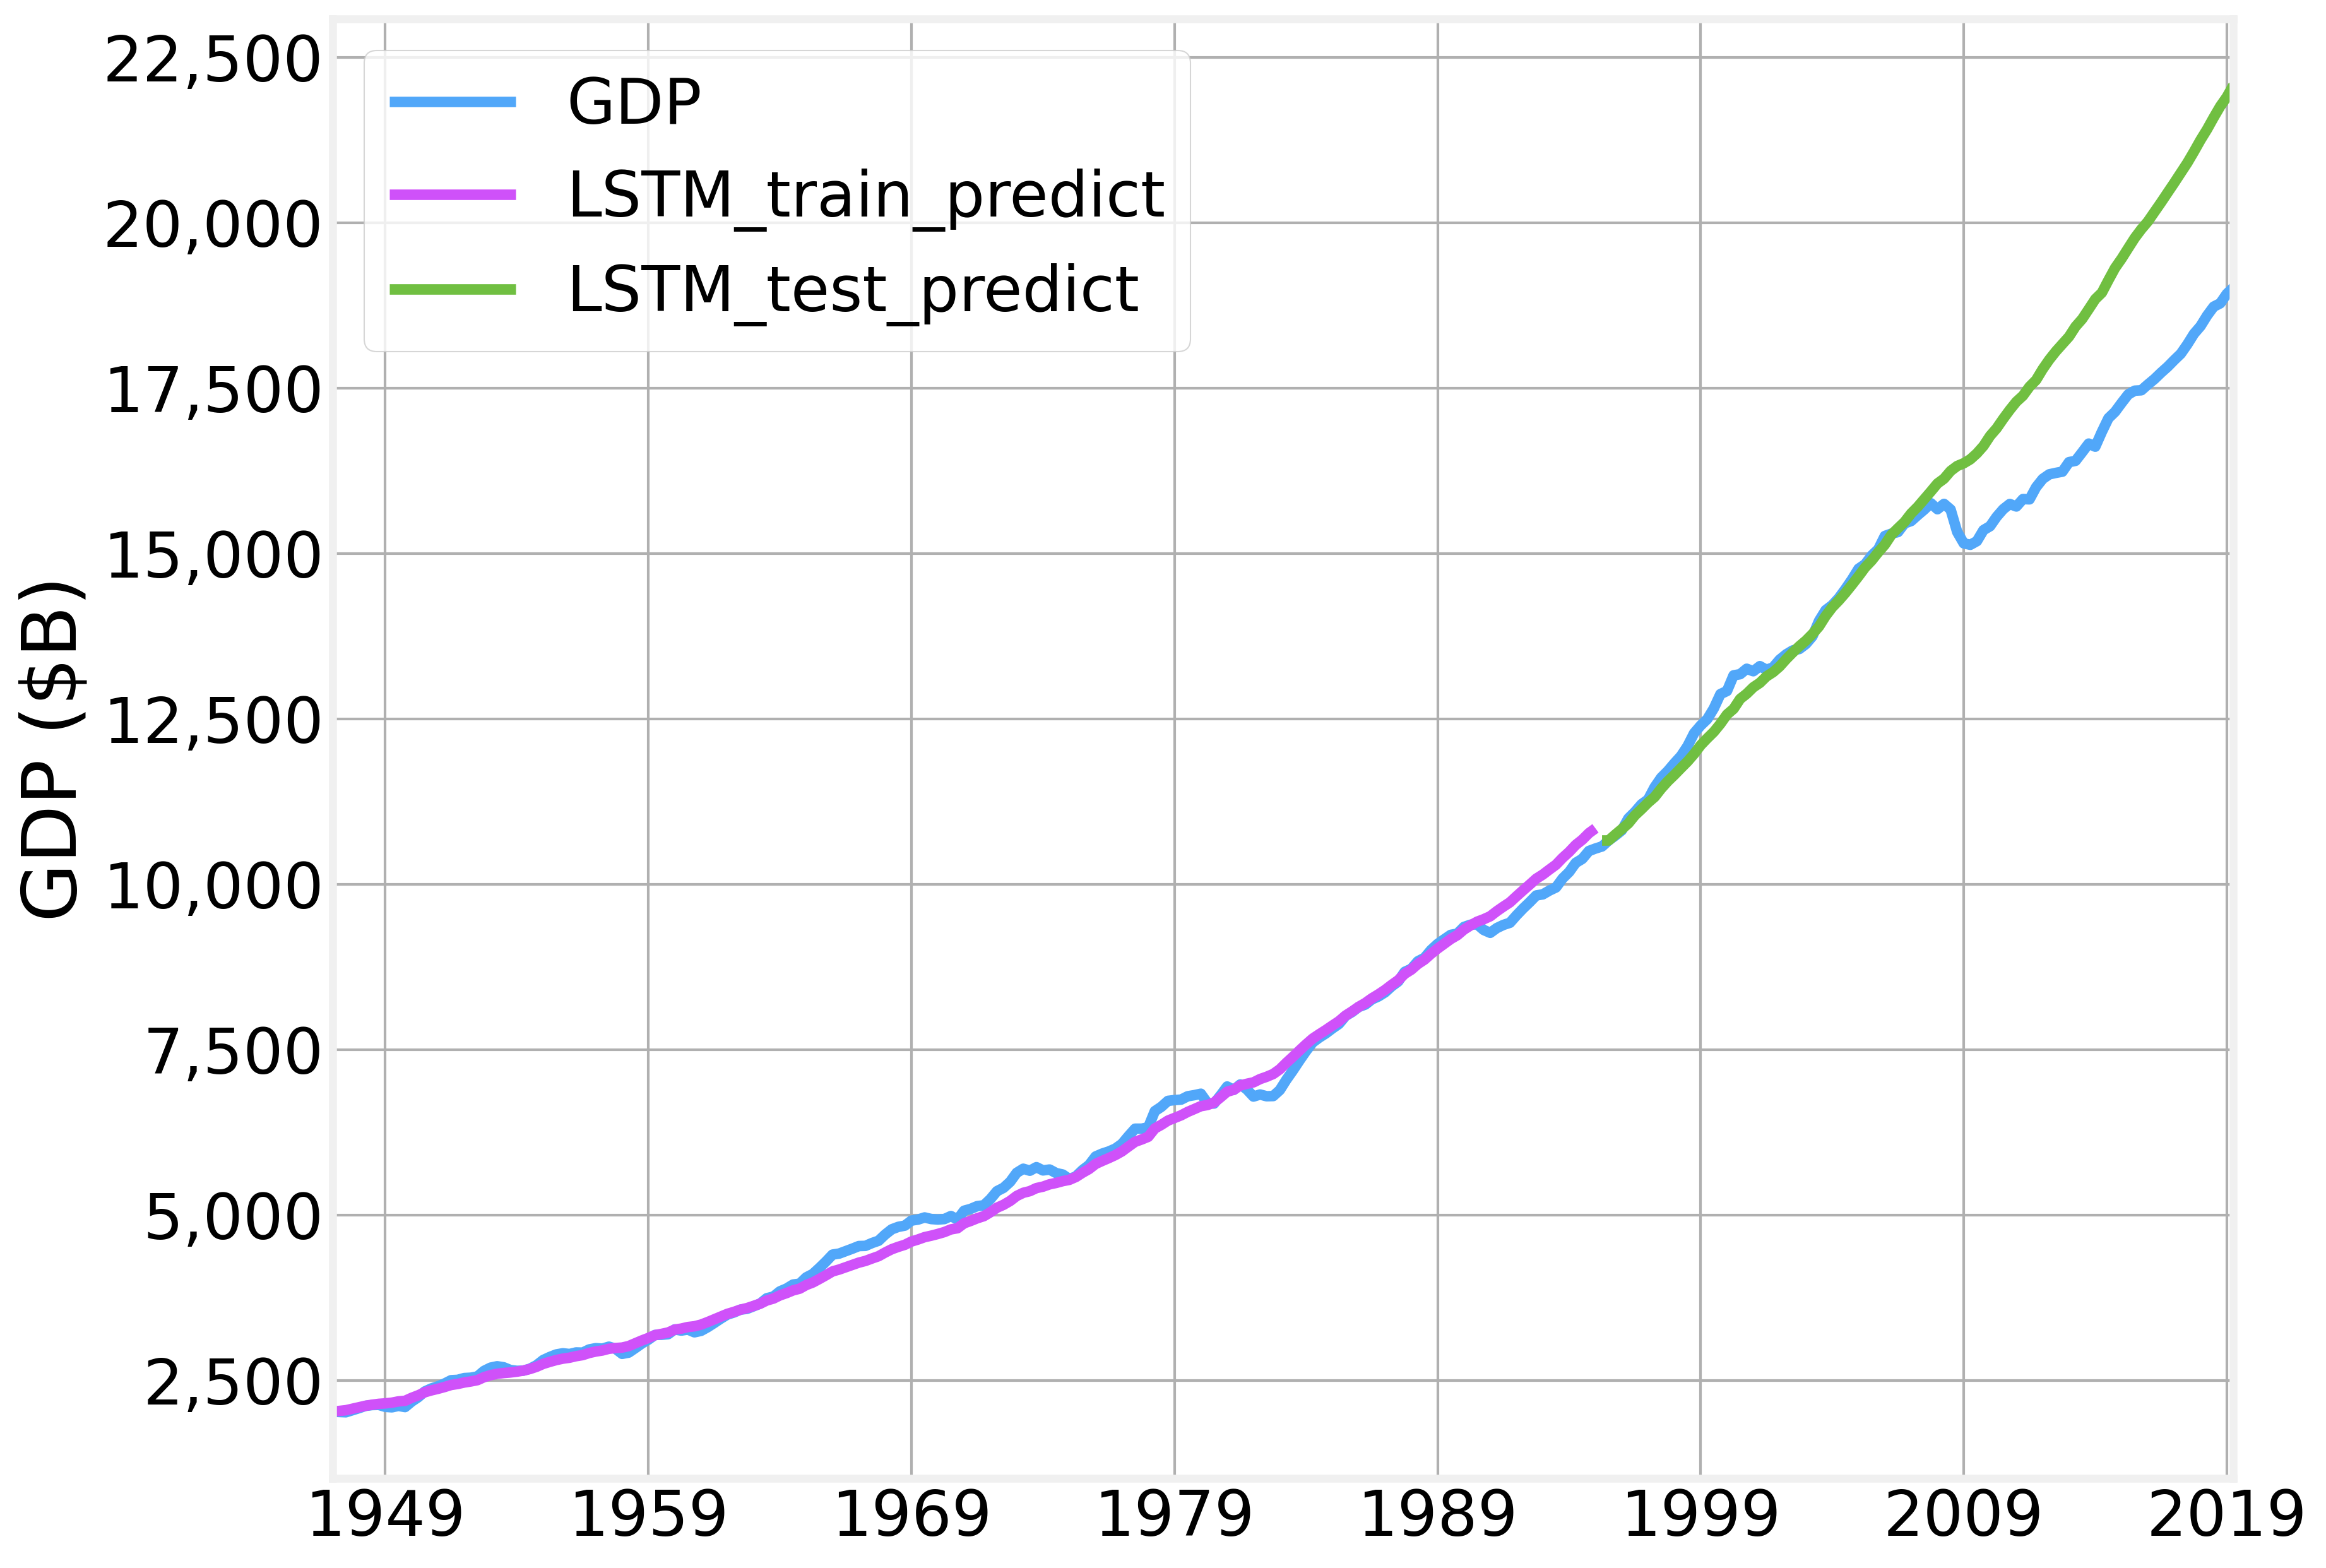

In [21]:
ax = dataset[['GDP']].plot()
# dataset[['RNN_train_predict']][:train_points].plot(ax=ax)
# dataset[['RNN_test_predict']][train_points:].plot(ax=ax)
dataset[['LSTM_train_predict']][:train_points].plot(ax=ax)
dataset[['LSTM_test_predict']][train_points:].plot(ax=ax)

ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

## Multiple timesteps
So far we've been using architectures with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

In [22]:
X2 = np.concatenate([X[0:-4], X[1:-3], X[2:-2], X[3:-1]], axis=1)
y2 = X[4:]

X2_train, X2_test = X2[:train_points], X2[train_points:]
y2_train, y2_test = y2[:train_points], y2[train_points:]

print("We have", X2_train.shape[0], "training points and", X2_test.shape[0], "testing points")

We have 193 training points and 91 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [23]:
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(193, 4, 1)
(91, 4, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [24]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [25]:
nb_epoch = 500
model.fit(X2_train, y2_train, epochs=nb_epoch, batch_size=12)

Epoch 1/500
17/17 [==============================] - 1s 2ms/step - loss: 0.1050
Epoch 2/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0992
Epoch 3/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0935
Epoch 4/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0988
Epoch 5/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0889
Epoch 6/500
17/17 [==============================] - 0s 1ms/step - loss: 0.0879
Epoch 7/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1072
Epoch 8/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1066
Epoch 9/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1007
Epoch 10/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1005
Epoch 11/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 12/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 13/500
17/17 [=================

17/17 [==============================] - 0s 2ms/step - loss: 0.0935
Epoch 102/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0816
Epoch 103/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0983
Epoch 104/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0808
Epoch 105/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0853
Epoch 106/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0916
Epoch 107/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0739
Epoch 108/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0992
Epoch 109/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0889
Epoch 110/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 111/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0781
Epoch 112/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0875
Epoch 113/500
17/17 [=========

17/17 [==============================] - 0s 2ms/step - loss: 0.0882
Epoch 202/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0831
Epoch 203/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0918
Epoch 204/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 205/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0883
Epoch 206/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1088
Epoch 207/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0792
Epoch 208/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0792
Epoch 209/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 210/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 211/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0901
Epoch 212/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1006
Epoch 213/500
17/17 [=========

17/17 [==============================] - 0s 2ms/step - loss: 0.0746
Epoch 302/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0882
Epoch 303/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0824
Epoch 304/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1028
Epoch 305/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0997
Epoch 306/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0987
Epoch 307/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0761
Epoch 308/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0893
Epoch 309/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0731
Epoch 310/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0871
Epoch 311/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0920
Epoch 312/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1025
Epoch 313/500
17/17 [=========

17/17 [==============================] - 0s 2ms/step - loss: 0.0897
Epoch 402/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0828
Epoch 403/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0822
Epoch 404/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0830
Epoch 405/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0956
Epoch 406/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0722
Epoch 407/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0777
Epoch 408/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0817
Epoch 409/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0696
Epoch 410/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1079
Epoch 411/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0853
Epoch 412/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0706
Epoch 413/500
17/17 [=========

In [26]:
y_train_pred = model.predict(X2_train)
y_test_pred = model.predict(X2_test)

dataset['LSTM3_train_predict'] = 1
dataset['LSTM3_test_predict'] = 1
dataset.loc[4:train_points+4, 'LSTM3_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+6:, 'LSTM3_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM3_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM3_train_predict'].cumprod()
dataset['LSTM3_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM3_test_predict'].cumprod()

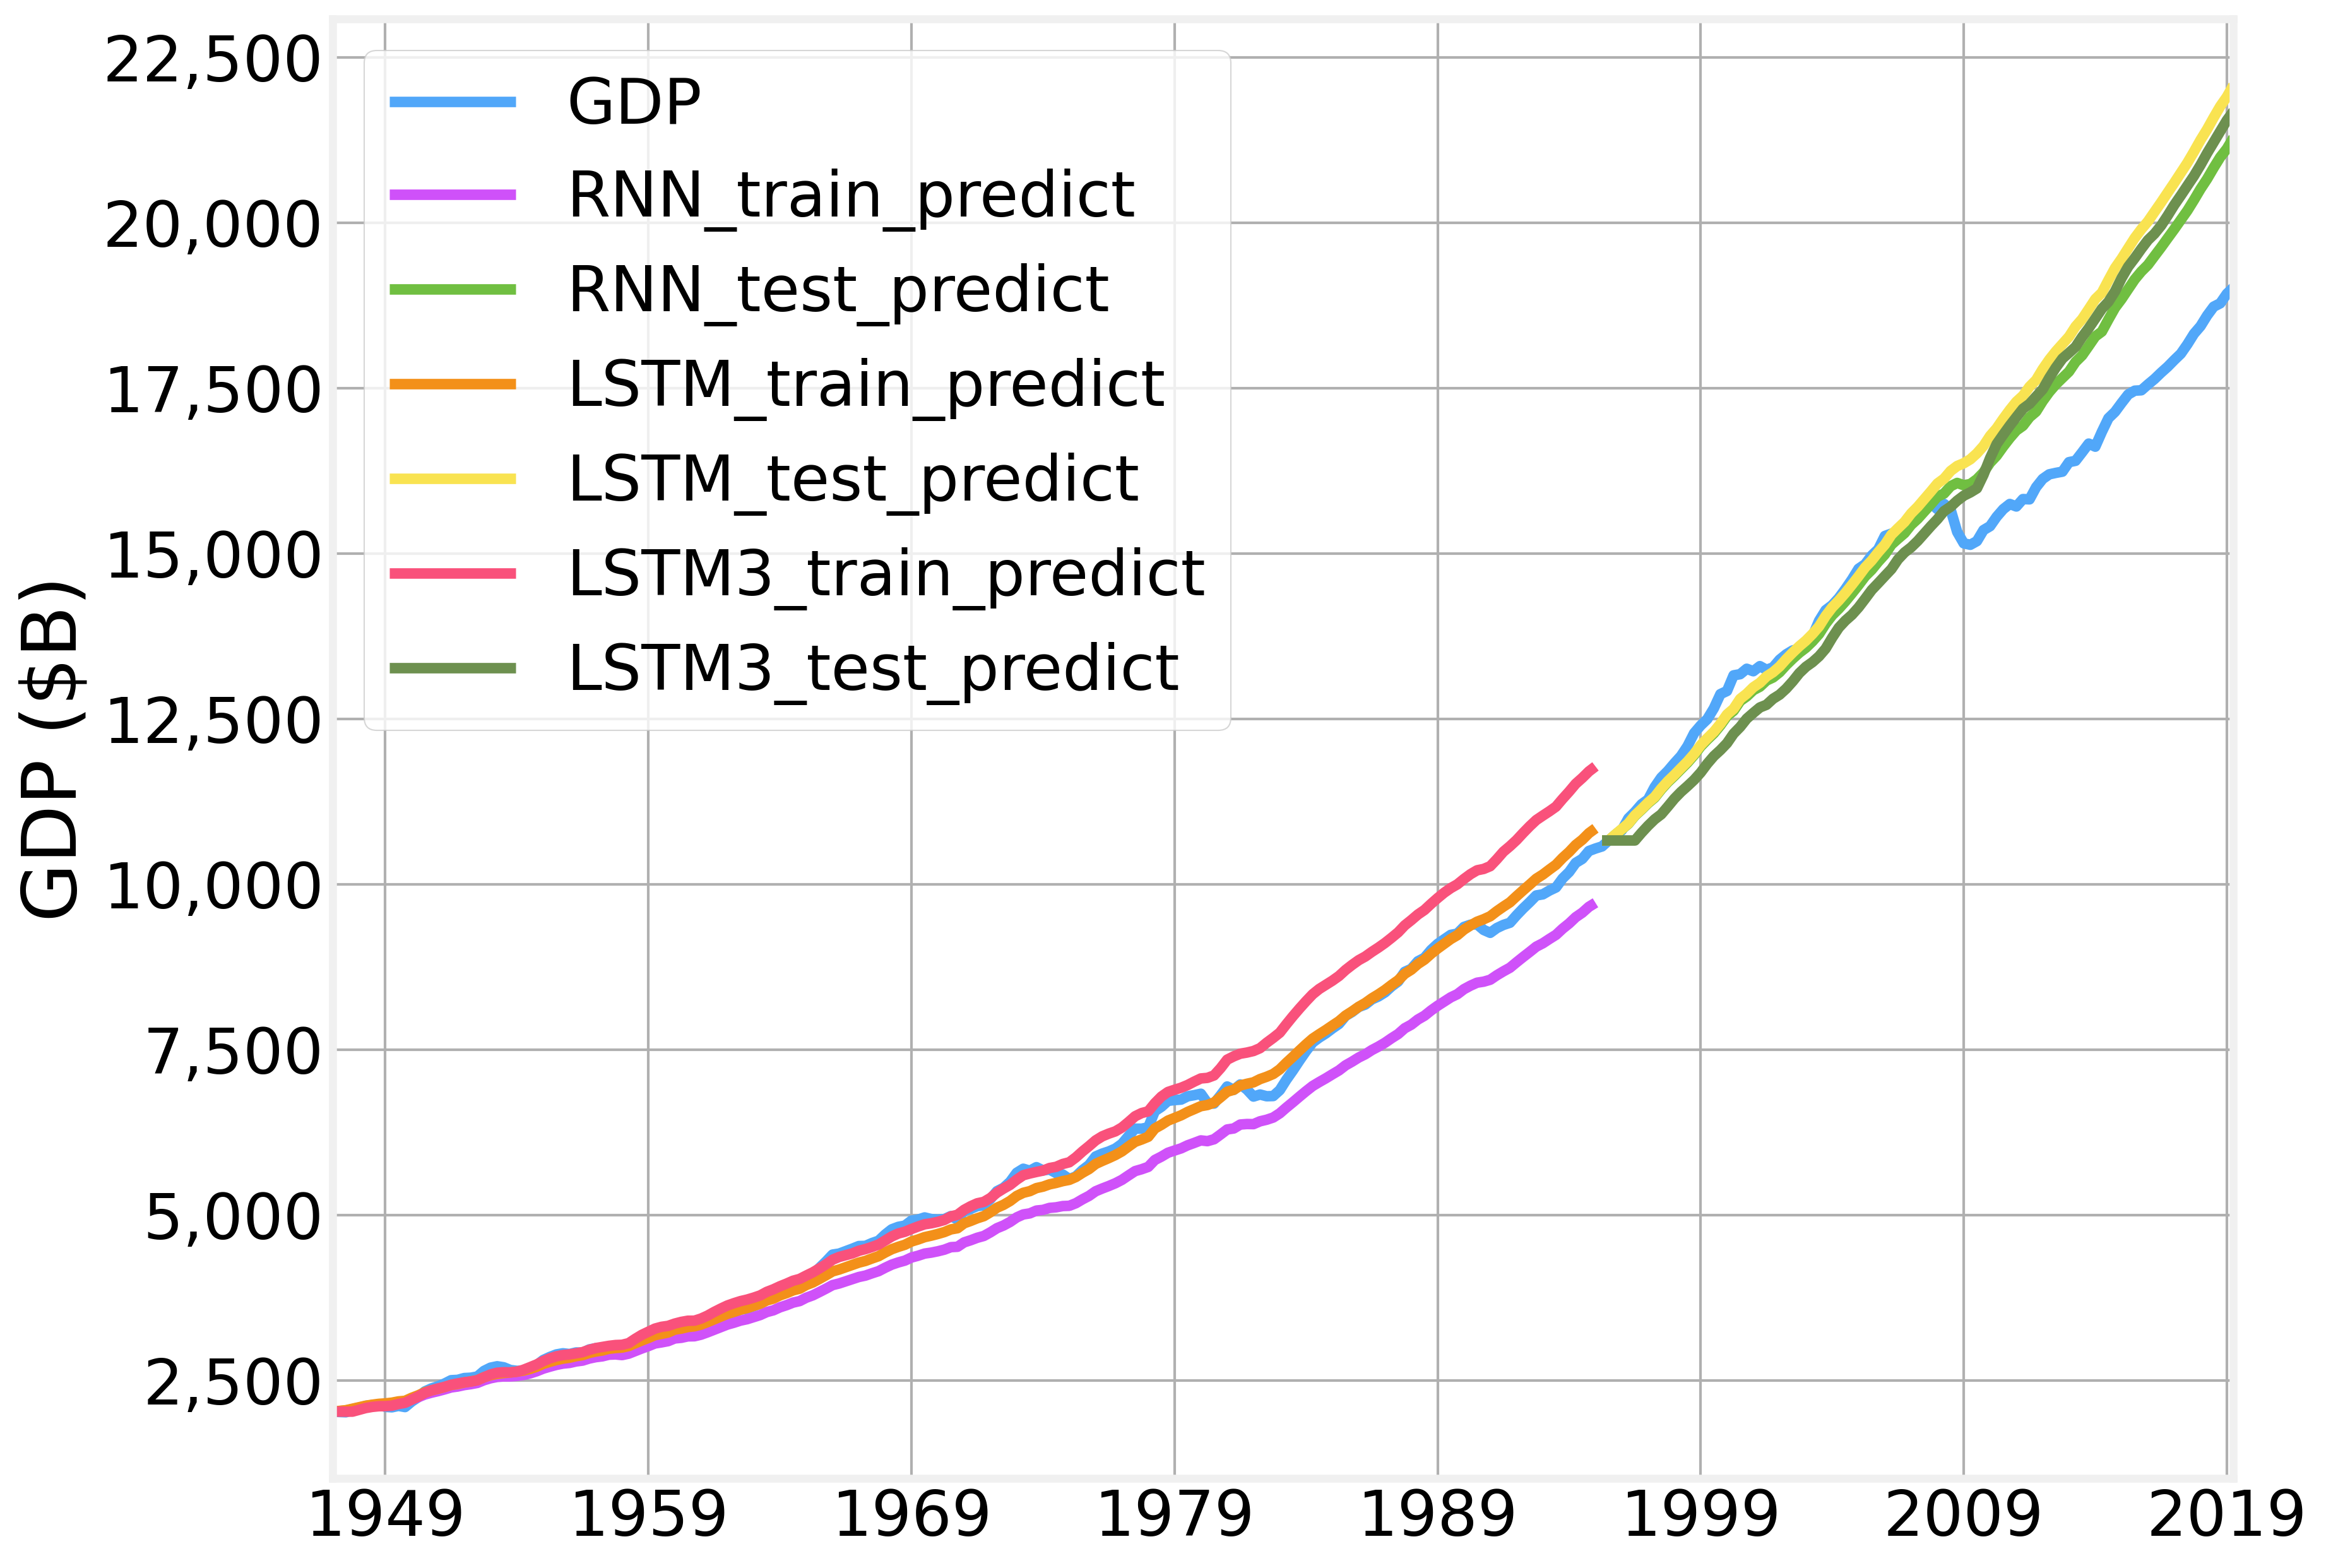

In [27]:
ax = dataset[['GDP']].plot()
dataset[['RNN_train_predict']][:train_points].plot(ax=ax)
dataset[['RNN_test_predict']][train_points:].plot(ax=ax)
dataset[['LSTM_train_predict']][:train_points].plot(ax=ax)
dataset[['LSTM_test_predict']][train_points:].plot(ax=ax)
dataset[['LSTM3_train_predict']][:train_points].plot(ax=ax)
dataset[['LSTM3_test_predict']][train_points:].plot(ax=ax)


ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

## GRU

Now we look at the GRU architecture, following similar approaches to the ones used above

In [28]:
model = Sequential()
model.add(GRU(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 4)                 84        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [30]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
7/7 [==============================] - 2s 2ms/step - loss: 0.0946
Epoch 2/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 3/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1094
Epoch 4/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0987
Epoch 5/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0940
Epoch 6/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0981
Epoch 7/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1148
Epoch 8/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0896
Epoch 9/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0900
Epoch 10/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0963
Epoch 11/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0940
Epoch 12/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1010
Epoch 13/500
7/7 [==============================] - 0s 1ms/st

7/7 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 105/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0873
Epoch 106/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0865
Epoch 107/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0997
Epoch 108/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1015
Epoch 109/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0903
Epoch 110/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0985
Epoch 111/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 112/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0964
Epoch 113/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0832
Epoch 114/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0916
Epoch 115/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0961
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.0923
Epoch 207/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0943
Epoch 208/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0896
Epoch 209/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0892
Epoch 210/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0837
Epoch 211/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0870
Epoch 212/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0923
Epoch 213/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0873
Epoch 214/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0932
Epoch 215/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0861
Epoch 216/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1064
Epoch 217/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0976
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.0911
Epoch 309/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1034
Epoch 310/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0916
Epoch 311/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1010
Epoch 312/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0933
Epoch 313/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0878
Epoch 314/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0900
Epoch 315/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0958
Epoch 316/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0940
Epoch 317/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1019
Epoch 318/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0862
Epoch 319/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0850
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.0895
Epoch 411/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 412/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1005
Epoch 413/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1025
Epoch 414/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0827
Epoch 415/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1043
Epoch 416/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 417/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0878
Epoch 418/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0849
Epoch 419/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0962
Epoch 420/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0861
Epoch 421/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0947
Epoch 422/500
7/7 [==============================] - 0

In [31]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['GRU_train_predict'] = 1
dataset['GRU_test_predict'] = 1
dataset.loc[1:train_points+1, 'GRU_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'GRU_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['GRU_train_predict'] = dataset.iloc[0]['GDP']*dataset['GRU_train_predict'].cumprod()
dataset['GRU_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['GRU_test_predict'].cumprod()

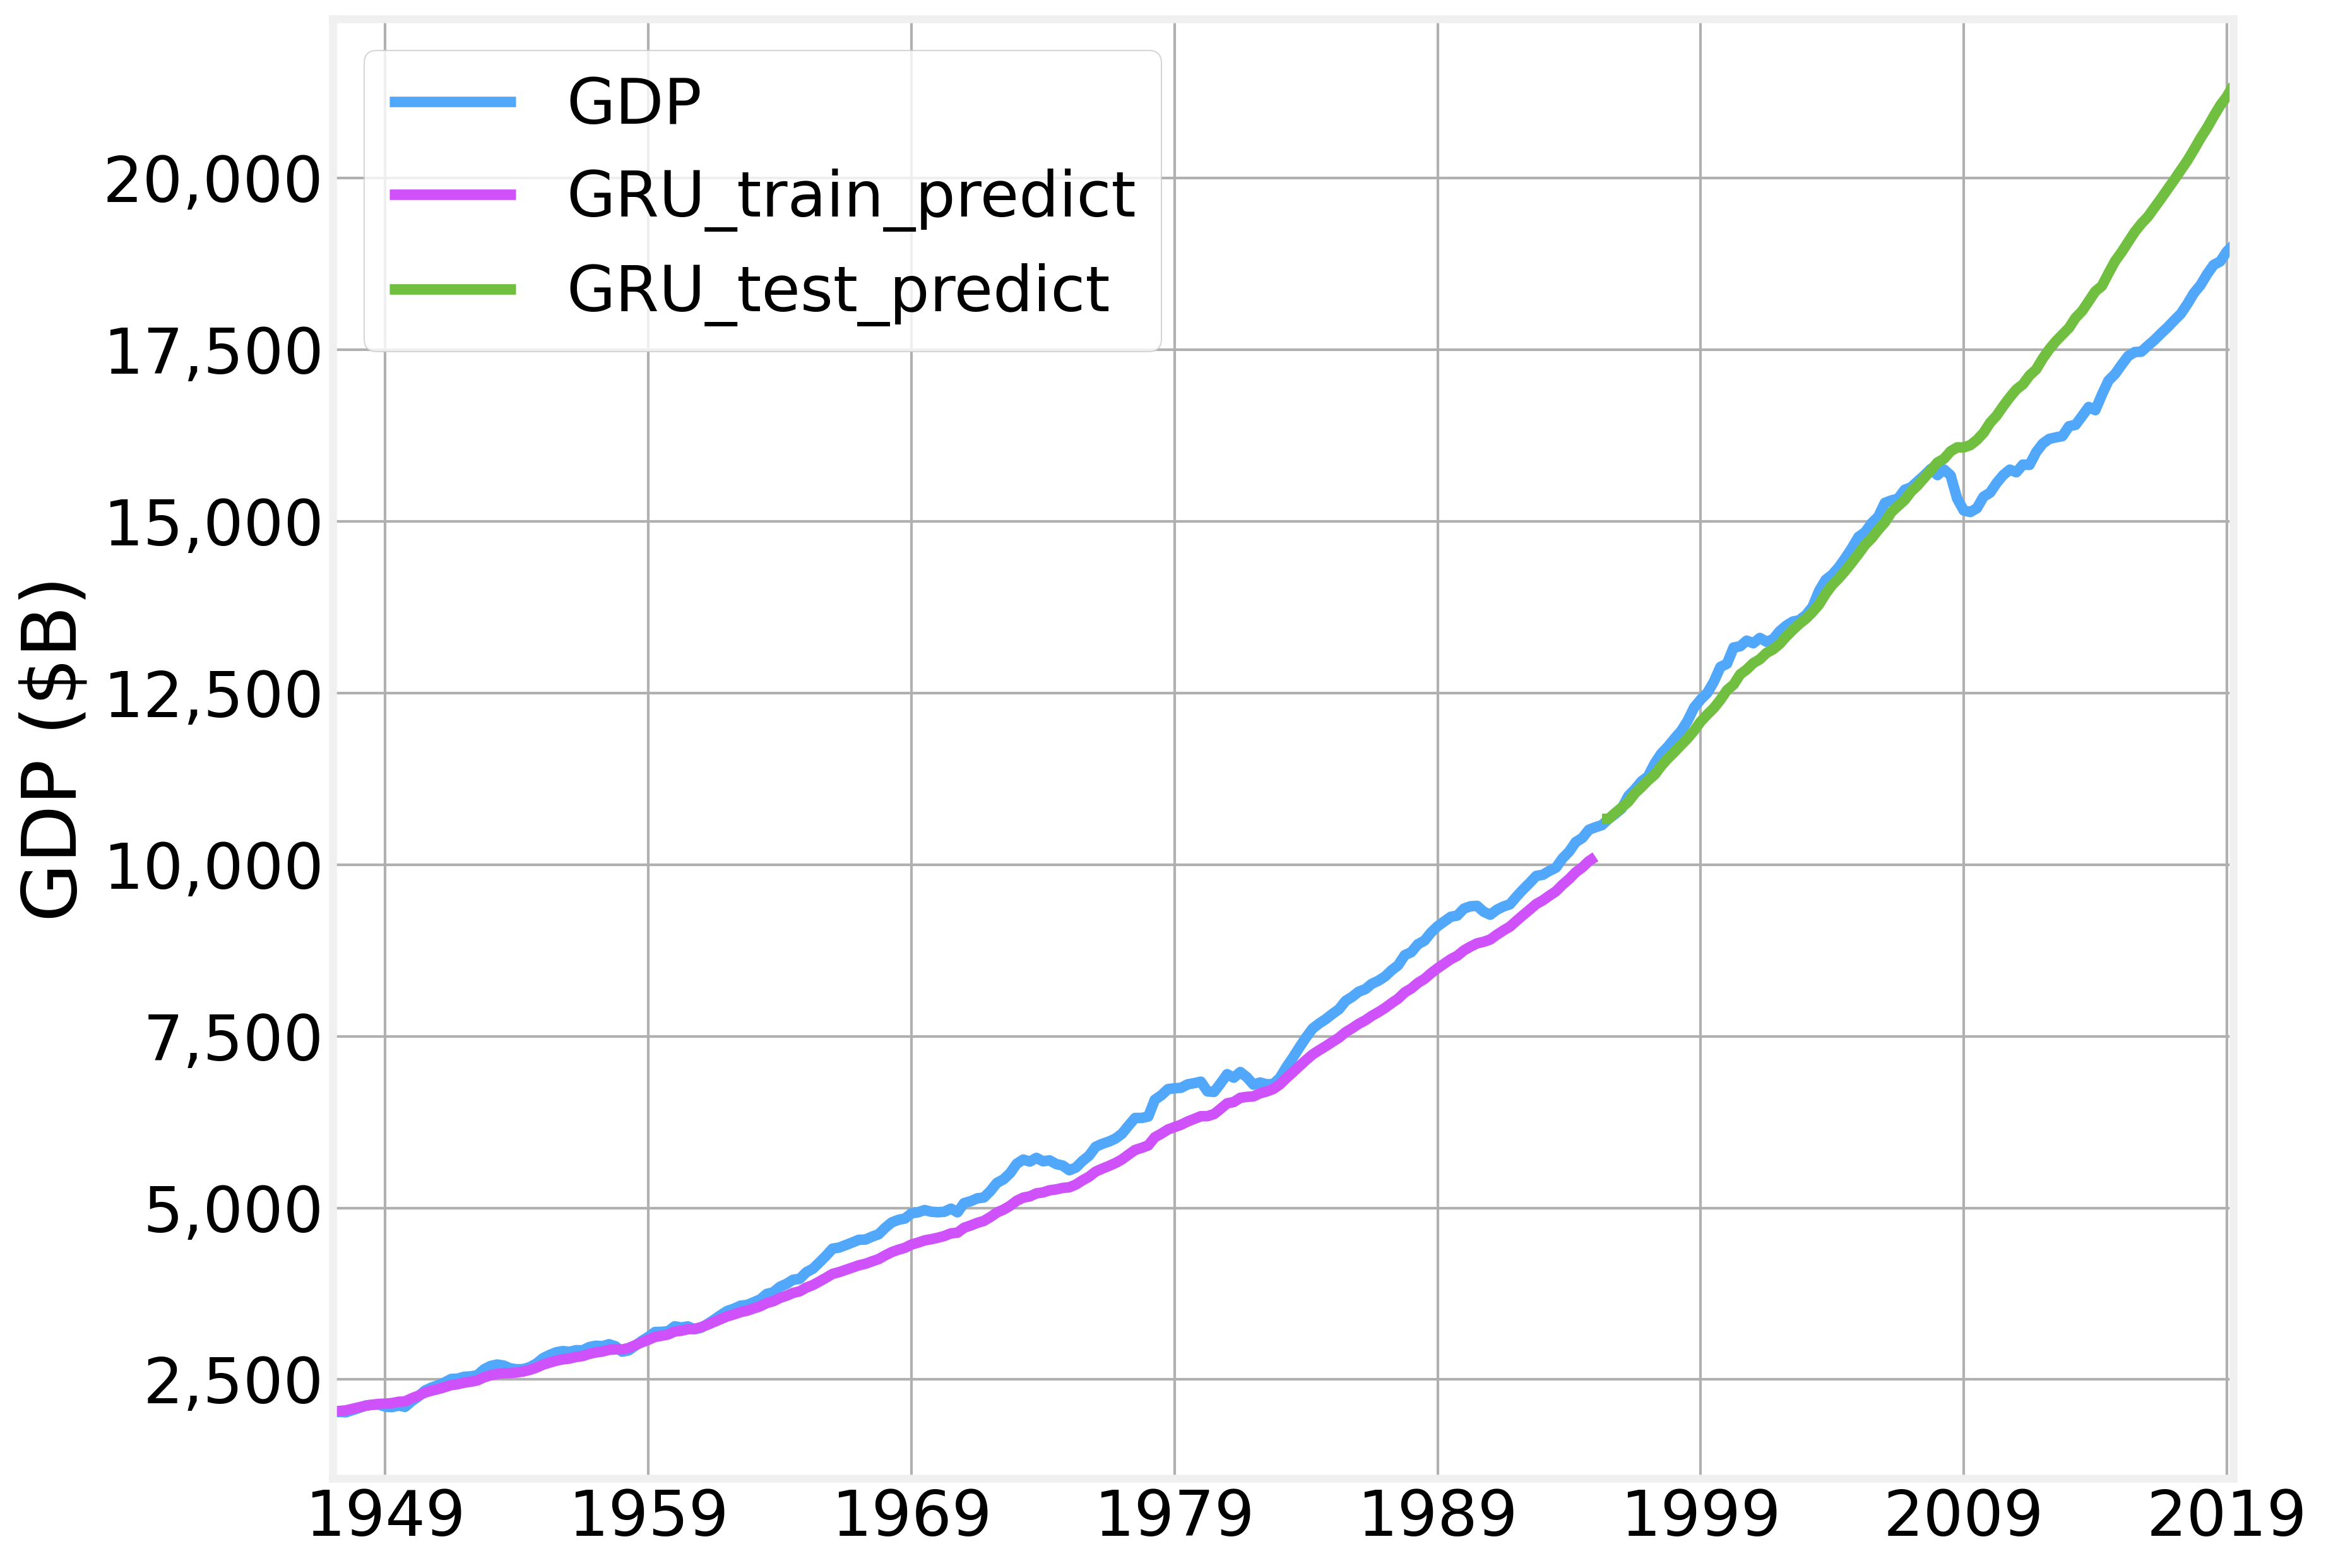

In [32]:
ax = dataset[['GDP']].plot()
dataset[['GRU_train_predict']][:train_points].plot(ax=ax)
dataset[['GRU_test_predict']][train_points:].plot(ax=ax)


ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

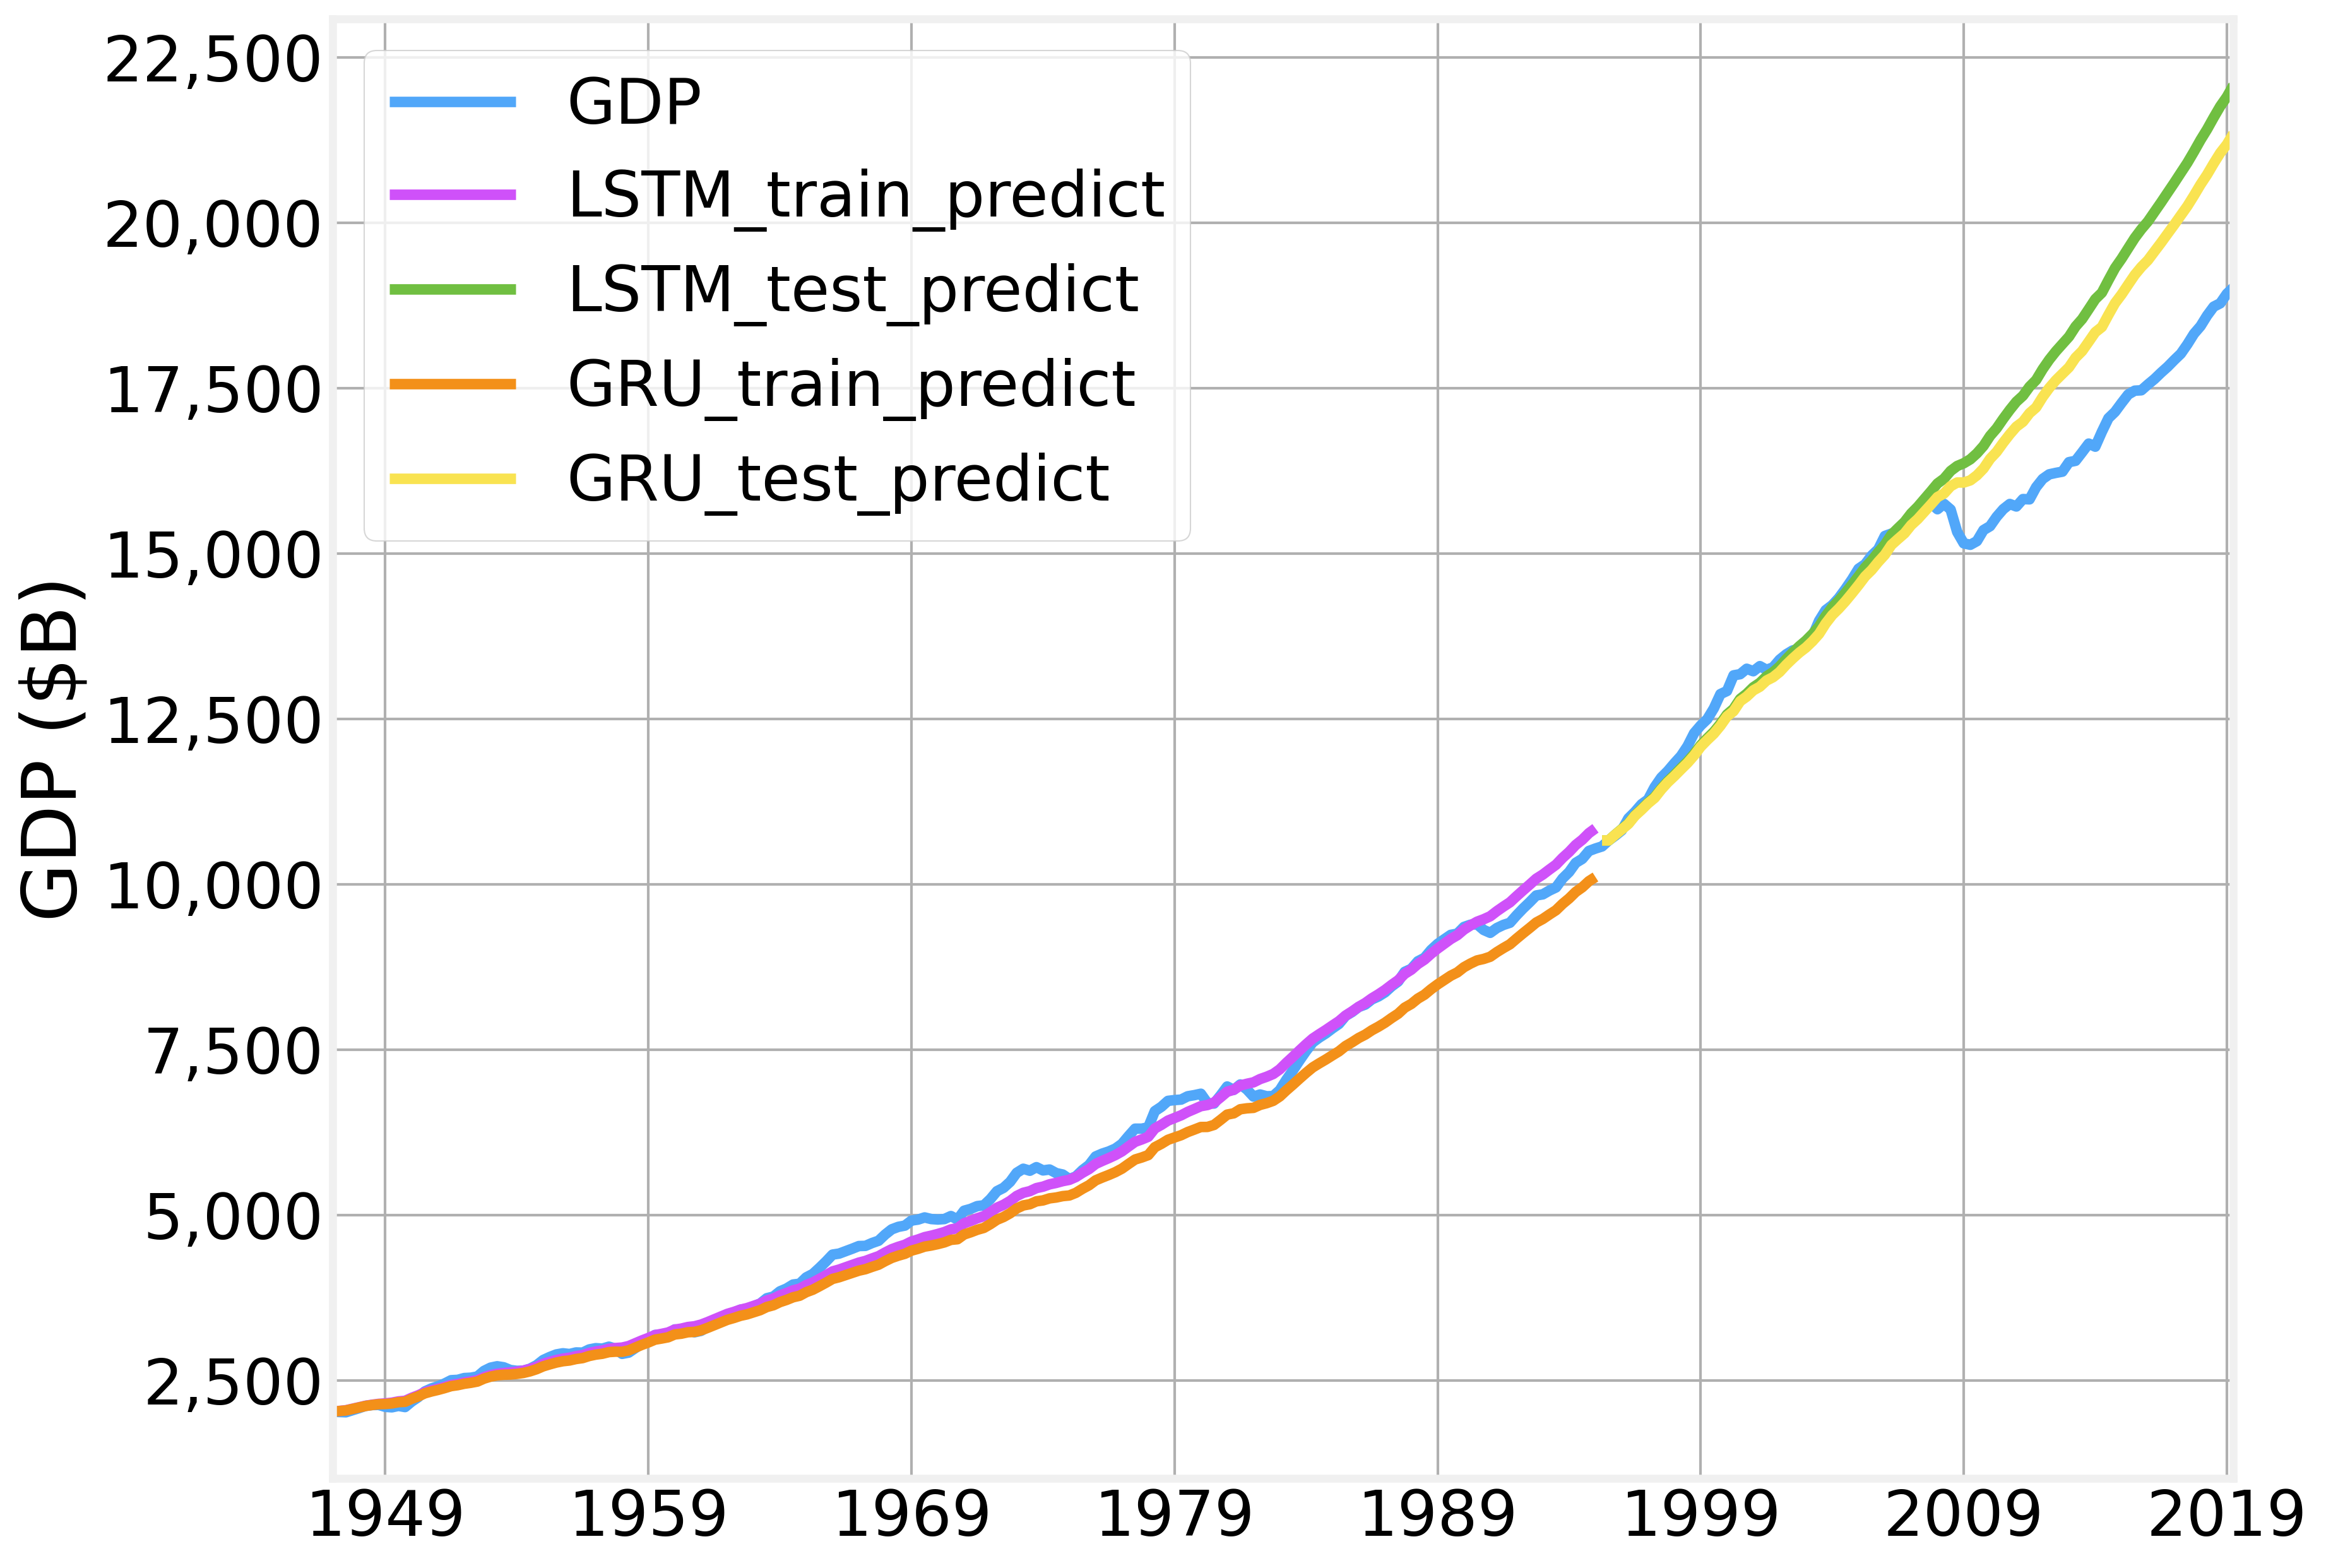

In [33]:
ax = dataset[['GDP']].plot()
dataset[['LSTM_train_predict']][:train_points].plot(ax=ax)
dataset[['LSTM_test_predict']][train_points:].plot(ax=ax)
dataset[['GRU_train_predict']][:train_points].plot(ax=ax)
dataset[['GRU_test_predict']][train_points:].plot(ax=ax)


ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>